In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
import random
import tensorflow as tf
from PIL import Image 
import cv2

'''
def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    return X, y
'''
def apply_augmentations(image):
    # Randomly flip the image horizontally
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    
    # Randomly flip the image vertically
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
    
    # Randomly rotate the image
    if tf.random.uniform(()) > 0.5:
        angle = tf.random.uniform([], minval=-30, maxval=30, dtype=tf.float32)
        image = tfa.image.rotate(image, angle)
    
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly translate the image
    if tf.random.uniform(()) > 0.5:
        tx = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
        ty = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
        image = tf.image.translate(image, [tx, ty])
    
    # Randomly zoom the image
    if tf.random.uniform(()) > 0.5:
        zoom_factor = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32)
        image = tf.image.central_crop(image, zoom_factor)
    
    return image


def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        # Load image using PIL and convert to RGB
        '''img = Image.open(img_loc_str).convert('RGB')
        #img = apply_augmentations(img)
        
        # Convert PIL image to numpy array
        img = np.array(img)
        
        #img = apply_augmentations(img)

        img = tf.image.resize(img, [299, 299])'''
        img = cv2.imread(img_loc_str)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentations
        img = empirical_regularization(img)
        img = random_crop(img)
        img = random_zoom(img)
        img = random_rotate(img)
        img = random_flip(img)
        img = adjust_contrast(img)
        img = random_translate(img)

        # Resize the image
        img = cv2.resize(img, (299, 299))
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0
        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label
    
    # Wrap the python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def empirical_regularization(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply GaussianBlur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Add Gaussian noise
    noisy = blurred + np.random.normal(0, 10, blurred.shape)
    # Clip values to be in [0, 255]
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    # Merge channels
    img = cv2.merge([noisy, noisy, noisy])
    return img

def random_crop(img):
    height, width, _ = img.shape
    # Set the cropping region
    top = np.random.randint(0, height // 4)
    bottom = height - np.random.randint(0, height // 4)
    left = np.random.randint(0, width // 4)
    right = width - np.random.randint(0, width // 4)
    # Crop the image
    img = img[top:bottom, left:right, :]
    return img

def random_zoom(img):
    # Randomly select a zoom factor
    zoom_factor = np.random.uniform(0.8, 1.2)
    # Get the zoomed image
    img = cv2.resize(img, (int(img.shape[1] * zoom_factor), int(img.shape[0] * zoom_factor)))
    return img

def random_rotate(img):
    # Randomly select a rotation angle between -15 and 15 degrees
    angle = np.random.uniform(-15, 15)
    # Get the rotation matrix
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
    # Apply the rotation
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img

def random_flip(img):
    # Randomly flip horizontally
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
    return img

def adjust_contrast(img):
    # Randomly adjust contrast
    alpha = np.random.uniform(0.8, 1.2)
    img = cv2.multiply(img, alpha)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def random_translate(img):
    # Randomly translate the image horizontally and vertically
    tx = np.random.randint(-20, 20)
    ty = np.random.randint(-20, 20)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-05 23:26:30.990814: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-05 23:26:30.990836: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-05 23:26:30.990839: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-05 23:26:30.991184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 23:26:30.991813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
print(type(tf_dataset_test))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [6]:
tf_dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
for images, labels in tf_dataset_val.take(1):
    print(images.shape)

(32, 299, 299, 3)


In [8]:
for images, labels in tf_dataset_train.take(1):
    print(images.dtype, labels.dtype)

<dtype: 'float32'> <dtype: 'int64'>


In [ ]:
image_height = 299
image_width = 299
image_channels = 3
num_classes = 1

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


history = model.fit(tf_dataset_train, 
                    epochs=25, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('my_model.h5')
loaded_model = tf.keras.models.load_model('my_model.h5')

Epoch 1/25


2023-12-05 23:26:56.930571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


115/442 [======>.......................] - ETA: 6:01 - loss: 1.5295 - accuracy: 0.6481

Epoch 1/20


2023-12-05 14:08:14.073922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 490s 1s/step - loss: 0.6778 - accuracy: 0.6507 - val_loss: 1.0298 - val_accuracy: 0.2310
Epoch 2/20
442/442 [==============================] - 509s 1s/step - loss: 0.2414 - accuracy: 0.6507 - val_loss: 0.5839 - val_accuracy: 0.2310
Epoch 3/20
442/442 [==============================] - 388s 876ms/step - loss: 0.2238 - accuracy: 0.6507 - val_loss: 1.2261 - val_accuracy: 0.2310
Epoch 4/20
442/442 [==============================] - 389s 877ms/step - loss: 0.1685 - accuracy: 0.6507 - val_loss: 1.2679 - val_accuracy: 0.2310
Epoch 5/20
442/442 [==============================] - 351s 790ms/step - loss: 0.1779 - accuracy: 0.6507 - val_loss: 9.7455 - val_accuracy: 0.2310
Epoch 6/20
442/442 [==============================] - 358s 806ms/step - loss: 0.1455 - accuracy: 0.6507 - val_loss: 10.4786 - val_accuracy: 0.2310
Epoch 7/20
442/442 [==============================] - 309s 696ms/step - loss: 0.1689 - accuracy: 0.6507 - val_loss: 13.9887 - val_accuracy: 

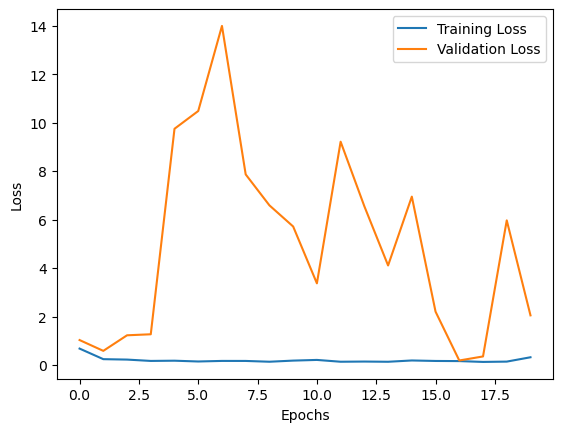

1/1 [==============================] - 0s 189ms/step
              precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

250/250 [==============================] - 32s 128ms/step - loss: 1.0162 - accuracy: 0.7243
Test Loss: 1.0161919593811035, Test Accuracy: 0.7242850065231323
[[2198    0]
 [5774    0]]


/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
image_height = 299
image_width = 299
image_channels = 3
num_classes = 1

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train, 
                    epochs=20, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('my_model.h5')
loaded_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
image_height = 299
image_width = 299
image_channels = 3
num_classes = 1

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train, 
                    epochs=20, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('my_model.h5')
loaded_model = tf.keras.models.load_model('my_model.h5')

16:10:44 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
16:10:44 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
16:10:44 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/20


2023-12-05 16:10:48.744218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 252s 558ms/step - loss: 0.5776 - accuracy: 0.6507 - val_loss: 1.4414 - val_accuracy: 0.2310
Epoch 2/20
442/442 [==============================] - 242s 546ms/step - loss: 0.5321 - accuracy: 0.6507 - val_loss: 0.9835 - val_accuracy: 0.2310
Epoch 3/20
442/442 [==============================] - 241s 545ms/step - loss: 0.5271 - accuracy: 0.6507 - val_loss: 0.4770 - val_accuracy: 0.2310
Epoch 4/20
442/442 [==============================] - 239s 541ms/step - loss: 0.5212 - accuracy: 0.6507 - val_loss: 3.0013 - val_accuracy: 0.2310
Epoch 5/20
442/442 [==============================] - 245s 554ms/step - loss: 0.5133 - accuracy: 0.6507 - val_loss: 0.9344 - val_accuracy: 0.2310
Epoch 6/20
442/442 [==============================] - 240s 543ms/step - loss: 0.5100 - accuracy: 0.6507 - val_loss: 0.8800 - val_accuracy: 0.2310
Epoch 7/20
442/442 [==============================] - 242s 546ms/step - loss: 0.5112 - accuracy: 0.6507 - val_loss: 1.8717 - val_accura

2023-12-05 16:43:06.972104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 287s 642ms/step - loss: 0.2387 - accuracy: 0.6507 - val_loss: 4.3268 - val_accuracy: 0.2310
Epoch 2/20
442/442 [==============================] - 272s 616ms/step - loss: 0.1912 - accuracy: 0.6507 - val_loss: 13.3855 - val_accuracy: 0.2310
Epoch 3/20
442/442 [==============================] - 273s 617ms/step - loss: 0.1778 - accuracy: 0.6507 - val_loss: 6.9884 - val_accuracy: 0.2310
Epoch 4/20
442/442 [==============================] - 272s 616ms/step - loss: 0.1681 - accuracy: 0.6507 - val_loss: 13.4306 - val_accuracy: 0.2310
Epoch 5/20
442/442 [==============================] - 273s 617ms/step - loss: 0.1590 - accuracy: 0.6507 - val_loss: 2.1792 - val_accuracy: 0.2310
Epoch 6/20
442/442 [==============================] - 272s 616ms/step - loss: 0.1564 - accuracy: 0.6507 - val_loss: 3.4867 - val_accuracy: 0.2310
Epoch 7/20
442/442 [==============================] - 272s 615ms/step - loss: 0.1579 - accuracy: 0.6507 - val_loss: 6.2922 - val_accu

2023-12-05 18:14:14.776563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 420s 944ms/step - loss: 0.0878 - accuracy: 0.6507 - val_loss: 2.9915 - val_accuracy: 0.2310
Epoch 2/20
442/442 [==============================] - 406s 919ms/step - loss: 0.0417 - accuracy: 0.6507 - val_loss: 1.9818 - val_accuracy: 0.2310
Epoch 3/20
442/442 [==============================] - 405s 917ms/step - loss: 0.0337 - accuracy: 0.6507 - val_loss: 1.7597 - val_accuracy: 0.2310
Epoch 4/20
442/442 [==============================] - 406s 920ms/step - loss: 0.0276 - accuracy: 0.6507 - val_loss: 1.6825 - val_accuracy: 0.2310
Epoch 5/20
442/442 [==============================] - 406s 918ms/step - loss: 0.0298 - accuracy: 0.6507 - val_loss: 3.5020 - val_accuracy: 0.2310
Epoch 6/20
442/442 [==============================] - 407s 921ms/step - loss: 0.0254 - accuracy: 0.6507 - val_loss: 3.2758 - val_accuracy: 0.2310
Epoch 7/20
442/442 [==============================] - 409s 925ms/step - loss: 0.0250 - accuracy: 0.6507 - val_loss: 1.4515 - val_accura

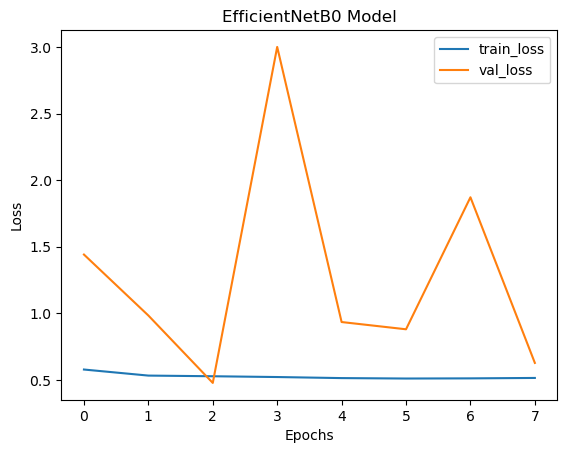

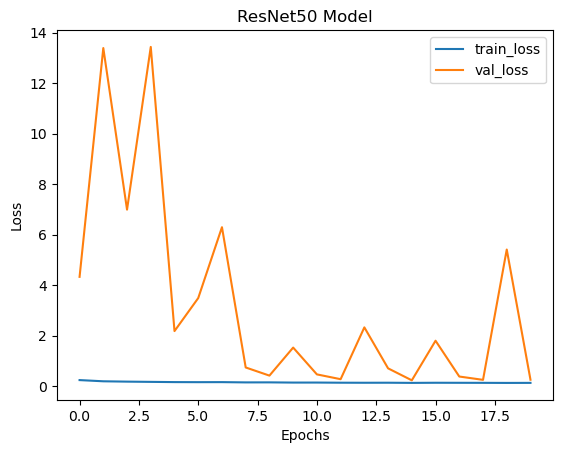

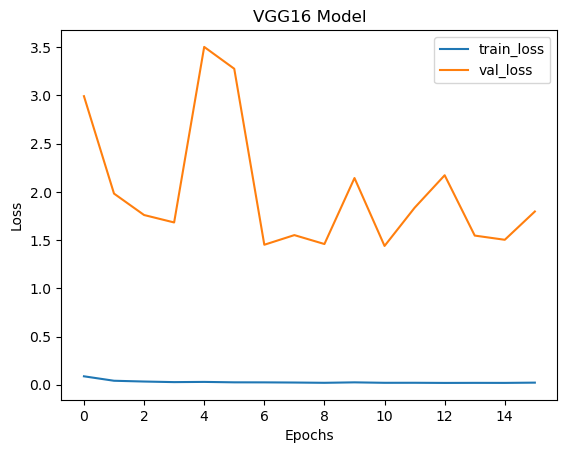

250/250 [==============================] - 151s 603ms/step - loss: 0.5247 - accuracy: 0.7243
EfficientNetB0 Test Loss: 1.1337916851043701
EfficientNetB0 Test Accuracy: 0.7242850065231323
ResNet50 Test Loss: 0.9284799695014954
ResNet50 Test Accuracy: 0.7242850065231323
VGG16 Test Loss: 0.5247166156768799
VGG16 Test Accuracy: 0.7242850065231323
250/250 [==============================] - 152s 608ms/step


NameError: name 'test_labels' is not defined

In [11]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

efficientnet_model = EfficientNetB0(include_top=False, input_shape=(299, 299, 3))
resnet_model = ResNet50(include_top=False, input_shape=(299, 299, 3))
vgg16_model = VGG16(include_top=False, input_shape=(299, 299, 3))

for layer in efficientnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg16_model.layers:
    layer.trainable = False

def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = 1

efficientnet_model = build_model(efficientnet_model)
resnet_model = build_model(resnet_model)
vgg16_model = build_model(vgg16_model)

def compile_model(model):
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

efficientnet_model = compile_model(efficientnet_model)
resnet_model = compile_model(resnet_model)
vgg16_model = compile_model(vgg16_model)

def train_model(model, tf_dataset_train, tf_dataset_val, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(tf_dataset_train, epochs=epochs, validation_data=tf_dataset_val, callbacks=[early_stopping])
    return history

# Train EfficientNetB0 model
efficientnet_history = train_model(efficientnet_model, tf_dataset_train, tf_dataset_val, epochs=25)

# Train ResNet50 model
resnet_history = train_model(resnet_model, tf_dataset_train, tf_dataset_val, epochs=25)

# Train VGG16 model
vgg16_history = train_model(vgg16_model, tf_dataset_train, tf_dataset_val, epochs=25)

# Plot training and validation errors
def plot_history(history, title):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(efficientnet_history, 'EfficientNetB0 Model')
plot_history(resnet_history, 'ResNet50 Model')
plot_history(vgg16_history, 'VGG16 Model')

# Evaluate models
def evaluate_model(model, tf_dataset_test):
    loss, accuracy = model.evaluate(tf_dataset_test)
    return loss, accuracy

efficientnet_loss, efficientnet_accuracy = evaluate_model(efficientnet_model, tf_dataset_test)
resnet_loss, resnet_accuracy = evaluate_model(resnet_model, tf_dataset_test)
vgg16_loss, vgg16_accuracy = evaluate_model(vgg16_model, tf_dataset_test)

print("EfficientNetB0 Test Loss:", efficientnet_loss)
print("EfficientNetB0 Test Accuracy:", efficientnet_accuracy)

print("ResNet50 Test Loss:", resnet_loss)
print("ResNet50 Test Accuracy:", resnet_accuracy)

print("VGG16 Test Loss:", vgg16_loss)
print("VGG16 Test Accuracy:", vgg16_accuracy)

y_true_eff = []
y_pred_eff = []

y_true_resnet = []
y_pred_resnet = []

y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in tf_dataset_test:
    y_true_vgg16.extend(labels.numpy())
    y_pred_vgg16.extend(np.argmax(vgg16_model.predict(images), axis=1))
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(efficientnet_model.predict(images), axis=1))
    
efficientnet_report = classification_report(y_true_eff, y_pred_eff, zero_division=1)
resnet_report = classification_report(y_true_resnet, y_pred_resnet, zero_division=1)
vgg16_report = classification_report(y_true_vgg16, y_pred_vgg16, zero_division=1)

print("EfficientNetB0 Classification Report:\n", efficientnet_report)
print("ResNet50 Classification Report:\n", resnet_report)
print("VGG16 Classification Report:\n", vgg16_report)

efficientnet_confusion_mtx = confusion_matrix(y_true_eff, y_pred_eff)
resnet_confusion_mtx = confusion_matrix(y_true_resnet, y_pred_resnet)
vgg16_confusion_mtx = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("EfficientNetB0 Confusion Matrix:\n", efficientnet_confusion_mtx)
print("ResNet50 Confusion Matrix:\n", resnet_confusion_mtx)
print("VGG16 Confusion Matrix:\n", vgg16_confusion_mtx)

In [14]:
y_true_eff = []
y_pred_eff = []

for images, labels in tf_dataset_test:
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(efficientnet_model.predict(images), axis=1))
    
y_true_resnet = []
y_pred_resnet = []

for images, labels in tf_dataset_test:
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))

y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in tf_dataset_test:
    y_true_vgg16.extend(labels.numpy())
    y_pred_vgg16.extend(np.argmax(vgg16_model.predict(images), axis=1))
    

1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 1s 537ms/step


In [15]:
efficientnet_report = classification_report(y_true_eff, y_pred_eff, zero_division=1)
resnet_report = classification_report(y_true_resnet, y_pred_resnet, zero_division=1)
vgg16_report = classification_report(y_true_vgg16, y_pred_vgg16, zero_division=1)

print("EfficientNetB0 Classification Report:\n", efficientnet_report)
print("ResNet50 Classification Report:\n", resnet_report)
print("VGG16 Classification Report:\n", vgg16_report)

efficientnet_confusion_mtx = confusion_matrix(y_true_eff, y_pred_eff)
resnet_confusion_mtx = confusion_matrix(y_true_resnet, y_pred_resnet)
vgg16_confusion_mtx = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("EfficientNetB0 Confusion Matrix:\n", efficientnet_confusion_mtx)
print("ResNet50 Confusion Matrix:\n", resnet_confusion_mtx)
print("VGG16 Confusion Matrix:\n", vgg16_confusion_mtx)

EfficientNetB0 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64   